# Data

- where do we draw a line between smoothing and linking?
    - sub 10GeV
    - 3-5cm cone

- need a step in between CLUE3D output and simulation

In [6]:
import uproot
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt

from reco.plotting import plot_sim_reco, plot_tracksters
from reco.dataset import match_trackster_pairs, get_ground_truth


# %matplotlib widget
%matplotlib inline

file_name = "~/Data/multi/new_ntuples_14992862_996.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

E_TH = 10

## Dataset preparation

Identify sub-10Gev tracksters

In [7]:
tenergy = ak.flatten(tracksters["raw_energy"].array())
stenergy = ak.flatten(simtracksters["stsSC_raw_energy"].array())

we have much two orders of magnitude more lareclusters in the sub 10 GeV range

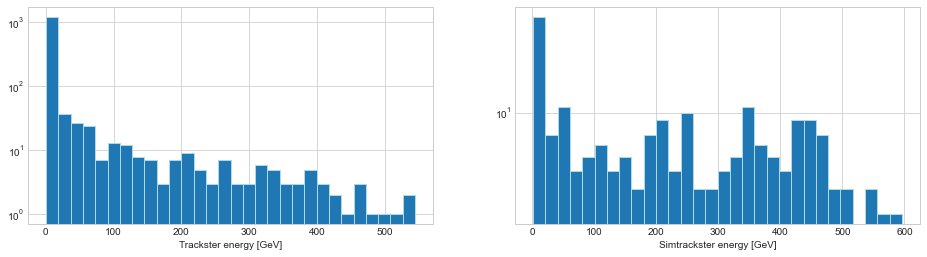

In [8]:
fig = plt.figure(figsize=(16, 4))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(121)
ax.hist(tenergy, bins=30, edgecolor="lightblue")
ax.set_yscale("log")
ax.set_xlabel("Trackster energy [GeV]")
ax = fig.add_subplot(122)
ax.set_xlabel("Simtrackster energy [GeV]")
ax.hist(stenergy, bins=30, edgecolor="lightblue")
ax.set_yscale("log")
plt.show()

In [9]:
e_pairs = [match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=E_TH,
    distance_threshold=100,
    distance_type="bary",
    confidence_threshold=0.5
) for eid in range(20)]

e_lc_pairs = [match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=E_TH,
    distance_threshold=100,
    distance_type="pairwise",
    confidence_threshold=0.5
) for eid in range(20)]

sub-10GeV tracksters distance from nearest large trackster from the same particle distribution

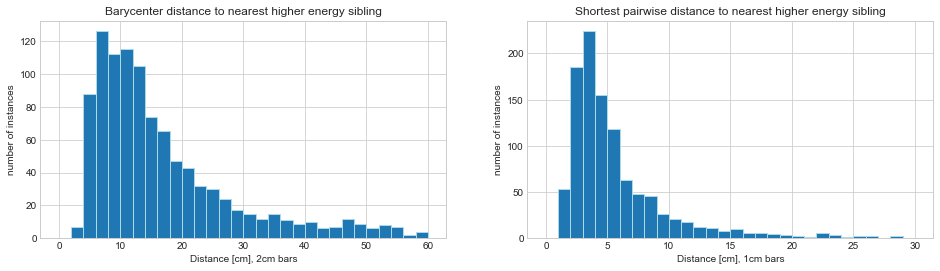

In [10]:
fig = plt.figure(figsize=(16, 4))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(121)
ax.hist(ak.flatten(e_pairs)[:,2], bins=30, edgecolor="lightblue", range=(0,60))
ax.set_title("Barycenter distance to nearest higher energy sibling")
ax.set_xlabel("Distance [cm], 2cm bars")
ax.set_ylabel("number of instances")

ax = fig.add_subplot(122)
ax.hist(ak.flatten(e_lc_pairs)[:,2], bins=30, edgecolor="lightblue", range=(0, 30))
ax.set_title("Shortest pairwise distance to nearest higher energy sibling")
ax.set_xlabel("Distance [cm], 1cm bars")
ax.set_ylabel("number of instances")

plt.show()

[30, 10, 18, 22, 23, 24, 25, 26, 28, 29, 37, 38, 39, 47, 48, 70, 73, 76, 77, 78, 84, 87]


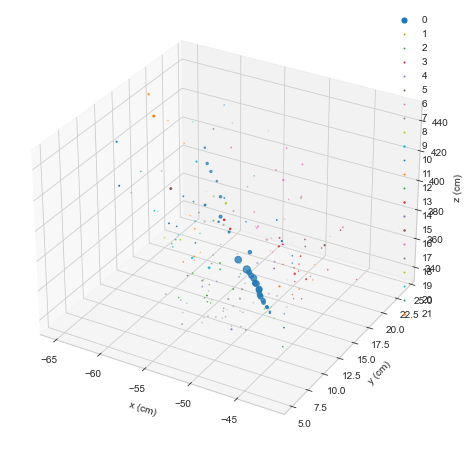

In [11]:
eid = 0
x_lc = tracksters["vertices_x"].array()[eid]
y_lc = tracksters["vertices_y"].array()[eid]
z_lc = tracksters["vertices_z"].array()[eid]
e_lc = tracksters["vertices_energy"].array()[eid]

p_id = 30
indices = [p_id]
fig = plt.figure(figsize=(10, 8))

for i, (tt, lt, dst) in enumerate(e_pairs[eid]):
    if lt == p_id:
        indices.append(tt)

ax = fig.add_subplot(111, projection='3d')
print(indices)
plot_tracksters(ax, x_lc[indices], y_lc[indices], z_lc[indices], e_lc[indices])
plt.legend()
plt.show()

In [12]:
gt = get_ground_truth(
    tracksters,
    simtracksters,
    associations,
    eid
)

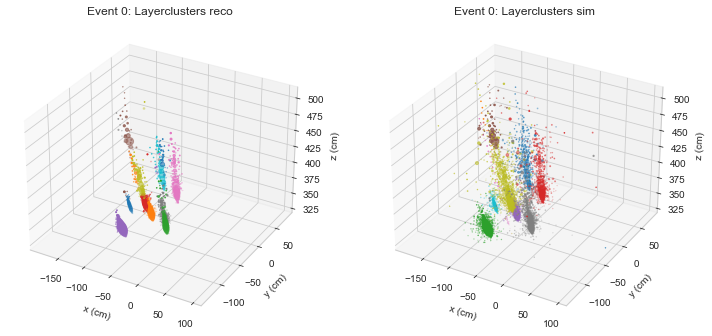

In [14]:
plot_sim_reco(
    gt["vertices_x"],
    gt["vertices_y"],
    gt["vertices_z"],
    gt["vertices_energy"],
    simtracksters["stsSC_vertices_x"].array()[eid],
    simtracksters["stsSC_vertices_y"].array()[eid],
    simtracksters["stsSC_vertices_z"].array()[eid],
    simtracksters["stsSC_vertices_energy"].array()[eid],
    simtracksters["stsSC_vertices_indexes"].array()[eid],
    simtracksters["stsSC_vertices_multiplicity"].array()[eid],
    eid,
    legend=False
)

In [15]:
# TODO: evaluation against the sim and energy profile comparison